In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import os
os.chdir('/content/drive/My Drive/project_captcha/dataset/')
!ls

captcha_labelled  combined  deskewed  label.csv  letters  processed


In [73]:
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, sampler, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchsummary import summary


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [74]:
np.random.seed(0)
torch.manual_seed(0)

In [75]:
''' Declaring important parameters '''

data_dir = 'letters'
nThreads = 4
batch_size = 64

## Loading/Splitting Dataset

In [ ]:
''' Loading dataset and splitting it into train and test set '''
def load_split_train_test(datadir, valid_size = .2):

    train_transforms = transforms.Compose([transforms.Resize(100),
                                           transforms.ToTensor(),
                                           ])
    test_transforms = transforms.Compose([transforms.Resize(100),
                                          transforms.ToTensor(),
                                          ])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = sampler.SubsetRandomSampler(train_idx)
    test_sampler = sampler.SubsetRandomSampler(test_idx)
    trainloader = DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(testloader.dataset.classes)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Another method of splitting

In [63]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ])
}

In [64]:
letters_dataset = datasets.ImageFolder(
                              root = data_dir,
                              transform = image_transforms["train"]
                       )

In [65]:
letters_dataset

Dataset ImageFolder
    Number of datapoints: 10355
    Root location: letters
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [66]:
print(letters_dataset.classes)
print(letters_dataset.class_to_idx)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, 'A': 8, 'C': 9, 'D': 10, 'E': 11, 'F': 12, 'G': 13, 'H': 14, 'J': 15, 'K': 16, 'M': 17, 'N': 18, 'P': 19, 'Q': 20, 'R': 21, 'S': 22, 'T': 23, 'U': 24, 'V': 25, 'W': 26, 'X': 27, 'Y': 28, 'Z': 29}


In [67]:
idx2class = {v: k for k, v in letters_dataset.class_to_idx.items()}
print(idx2class)

{0: '2', 1: '3', 2: '4', 3: '5', 4: '6', 5: '7', 6: '8', 7: '9', 8: 'A', 9: 'C', 10: 'D', 11: 'E', 12: 'F', 13: 'G', 14: 'H', 15: 'J', 16: 'K', 17: 'M', 18: 'N', 19: 'P', 20: 'Q', 21: 'R', 22: 'S', 23: 'T', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z'}


In [68]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
# print("Distribution of classes: \n", get_class_distribution(letters_dataset))


In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(letters_dataset)]).melt(),
            x = "variable", y="value", hue="variable").set_title('Letters Class Distribution')

Random split

In [69]:
train_dataset, val_dataset = random_split(letters_dataset, (8000, 2355))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=64)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))


Length of the train_loader: 282
Length of the val_loader: 43


In [ ]:
''' Vizualize Images from dataloader '''

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
image = np.transpose(images[0].numpy(), (1, 2, 0))
image = image.reshape(100,100)
print(set(image.flatten()))
plt.imshow(image, cmap='gray')

Model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cuda


##Training

In [51]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2),
            nn.Conv2d(16,32,kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2))

        self.fc_model = nn.Sequential(
            nn.Linear(2592, 1024), # (N, 2592) -> (N, 512)
            nn.ReLU(),
            nn.Linear(1024, 30))  # (N, 512)  -> (N, 30)) #30 classes

    def forward(self, x):
        # print(x.shape)
        x = self.cnn_model(x)
        # print(x.shape) 
        x = x.view(x.size(0), -1)
        # print(x.shape)    
        x = self.fc_model(x)
        # print(x.shape)
        return x

In [52]:
model = CustomNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [53]:
summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 96, 96]             156
              ReLU-2            [-1, 6, 96, 96]               0
         AvgPool2d-3            [-1, 6, 48, 48]               0
            Conv2d-4           [-1, 16, 44, 44]           2,416
              ReLU-5           [-1, 16, 44, 44]               0
         AvgPool2d-6           [-1, 16, 22, 22]               0
            Conv2d-7           [-1, 32, 18, 18]          12,832
              ReLU-8           [-1, 32, 18, 18]               0
         AvgPool2d-9             [-1, 32, 9, 9]               0
           Linear-10                 [-1, 1024]       2,655,232
             ReLU-11                 [-1, 1024]               0
           Linear-12                   [-1, 30]          30,750
Total params: 2,701,386
Trainable params: 2,701,386
Non-trainable params: 0
---------------------------

In [54]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,701,386 total parameters.
2,701,386 training parameters.


In [55]:
def evaluation(dataloader):
    total, correct = 0, 0
    #keeping the network in evaluation mode 
    model.eval()
    for data in dataloader:
        inputs, labels = data
        #moving the inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [56]:
iter = []
loss_arr = []
loss_epoch_arr = []
max_epochs = 10 #epoch count

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        # print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        # print()
        #forward pass
        outputs = model(inputs)
        # print('a')
        loss = loss_fn(outputs, labels)
        
        #backward and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (i+1)%25 ==0:
            iter.append(i)
            loss_arr.append(loss.item())
            print('Epoch: %d/%d, Iterations: %d/%d, Loss: %0.4f, Test acc: %0.2f, Train acc: %0.2f' % (epoch+1, max_epochs, i+1, len(train_loader), loss.data, evaluation(val_loader), evaluation(train_loader)))
    loss_epoch_arr.append(loss.item())
        
    # print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(val_loader), evaluation(train_loader)))


Epoch: 1/10, Iterations: 25/125, Loss: 3.2166, Test acc: 9.17, Train acc: 8.66
Epoch: 1/10, Iterations: 50/125, Loss: 1.1611, Test acc: 63.61, Train acc: 65.35
Epoch: 1/10, Iterations: 75/125, Loss: 0.4093, Test acc: 90.23, Train acc: 89.41
Epoch: 1/10, Iterations: 100/125, Loss: 0.1572, Test acc: 92.48, Train acc: 93.01
Epoch: 1/10, Iterations: 125/125, Loss: 0.3362, Test acc: 93.63, Train acc: 93.31
Epoch: 2/10, Iterations: 25/125, Loss: 0.3774, Test acc: 94.18, Train acc: 94.74
Epoch: 2/10, Iterations: 50/125, Loss: 0.0919, Test acc: 94.56, Train acc: 95.41
Epoch: 2/10, Iterations: 75/125, Loss: 0.0826, Test acc: 95.20, Train acc: 96.38
Epoch: 2/10, Iterations: 100/125, Loss: 0.1112, Test acc: 95.41, Train acc: 96.35
Epoch: 2/10, Iterations: 125/125, Loss: 0.2587, Test acc: 95.88, Train acc: 97.15
Epoch: 3/10, Iterations: 25/125, Loss: 0.0675, Test acc: 96.31, Train acc: 97.79
Epoch: 3/10, Iterations: 50/125, Loss: 0.0547, Test acc: 96.01, Train acc: 98.08
Epoch: 3/10, Iterations: 7

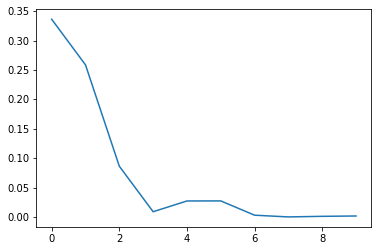

In [57]:
plt.plot(loss_epoch_arr)
plt.show()

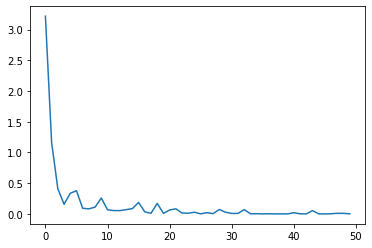

In [58]:
plt.plot(loss_arr)
plt.show()

In [59]:
model_path = '../models/pytorch/lenet3.pth'
torch.save(model.state_dict(), model_path)

In [60]:
full_model_path = '../models/pytorch/lenet3_full.pth'
torch.save(model, full_model_path)

## Inference

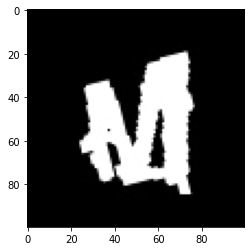

In [ ]:
from PIL import Image
img = Image.open('letters/M/512.jpg')
# img = cv2.imread('letters/2/24.jpg',-1)
plt.imshow(img,cmap='gray')

In [ ]:
img_t = image_transforms["train"](img)
batch_t = torch.unsqueeze(img_t, 0)


In [ ]:
full_model_path = '../models/pytorch/lenet2_full.pth'
model = torch.load(full_model_path)
model.eval()

CustomNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=2592, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=30, bias=True)
  )
)

In [ ]:
out = model(batch_t.to(device))
print(out.shape)

torch.Size([1, 30])


In [ ]:
prediction = int(torch.max(out.cpu().data, 1)[1].numpy())
print(prediction)

17


In [ ]:
letter = idx2class[prediction]
print(letter)

M
